In [77]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from numpy.random import seed, randn
from sklearn.ensemble import BaggingClassifier

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 13

In [4]:
import pandas as pd
housing_train = pd.read_csv("train.csv")
housing_test= pd.read_csv("test.csv")
housing_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Definimos y como la informacion que queremos, y x con la que estimaremos
y=housing_train.SalePrice
x=housing_train.drop(columns="SalePrice")

In [6]:
#Importamos mas librerias para nuestro analisis
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split,cross_validate


In [100]:
#Corremos Column Selector con dos transformers, SimpleImputer para eliminar NaN y StandarScaler para poder utilizar PCA
column_selector = ColumnTransformer(
    [("label_bin", make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"),StandardScaler()), ["MSZoning","Utilities","LotConfig","Condition1","Condition2","BldgType","HouseStyle","OverallQual","OverallCond","KitchenQual","SaleCondition"]),
    ("numeric", make_pipeline(SimpleImputer(),StandardScaler()), make_column_selector(dtype_include=np.number))]
)

columns_ohe = column_selector.fit_transform(x)
columns_ohe

array([[-0.08304548, -0.21585871, -0.10526316, ..., -0.08768781,
        -1.5991111 ,  0.13877749],
       [-0.08304548, -0.21585871, -0.10526316, ..., -0.08768781,
        -0.48911005, -0.61443862],
       [-0.08304548, -0.21585871, -0.10526316, ..., -0.08768781,
         0.99089135,  0.13877749],
       ...,
       [-0.08304548, -0.21585871, -0.10526316, ...,  4.95311151,
        -0.48911005,  1.64520971],
       [-0.08304548, -0.21585871, -0.10526316, ..., -0.08768781,
        -0.8591104 ,  1.64520971],
       [-0.08304548, -0.21585871, -0.10526316, ..., -0.08768781,
        -0.1191097 ,  0.13877749]])

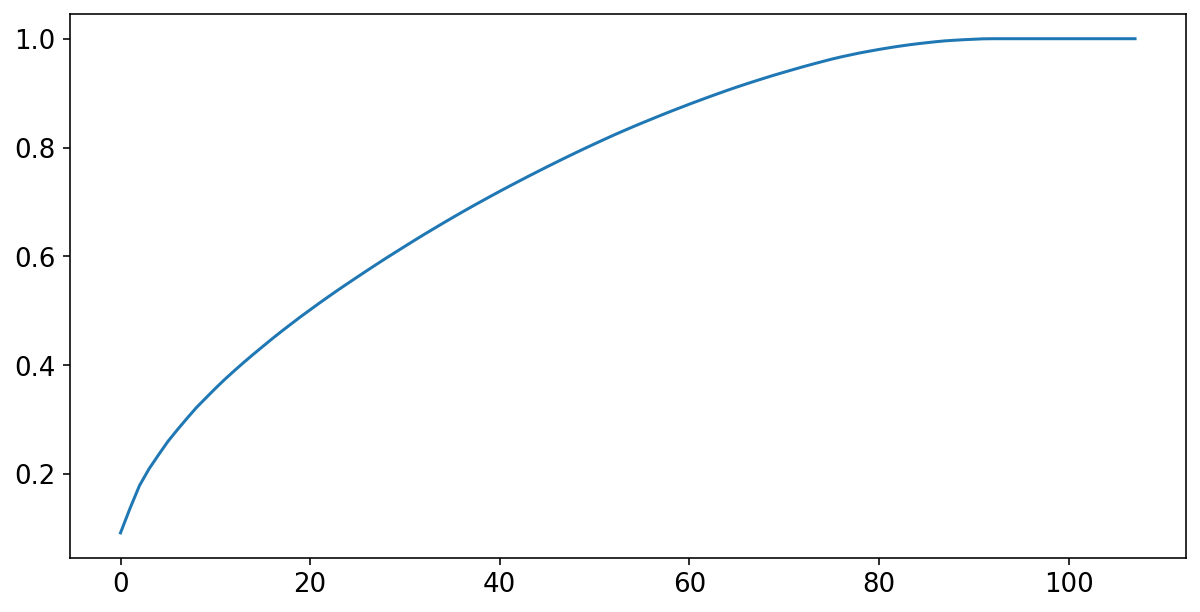

In [101]:
#Aplicamos PCA y graficamos para analizar en cuantas de nuestras varables se encuentra la mayor variabilidad
pca= PCA(svd_solver="full")
pca.fit(columns_ohe)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

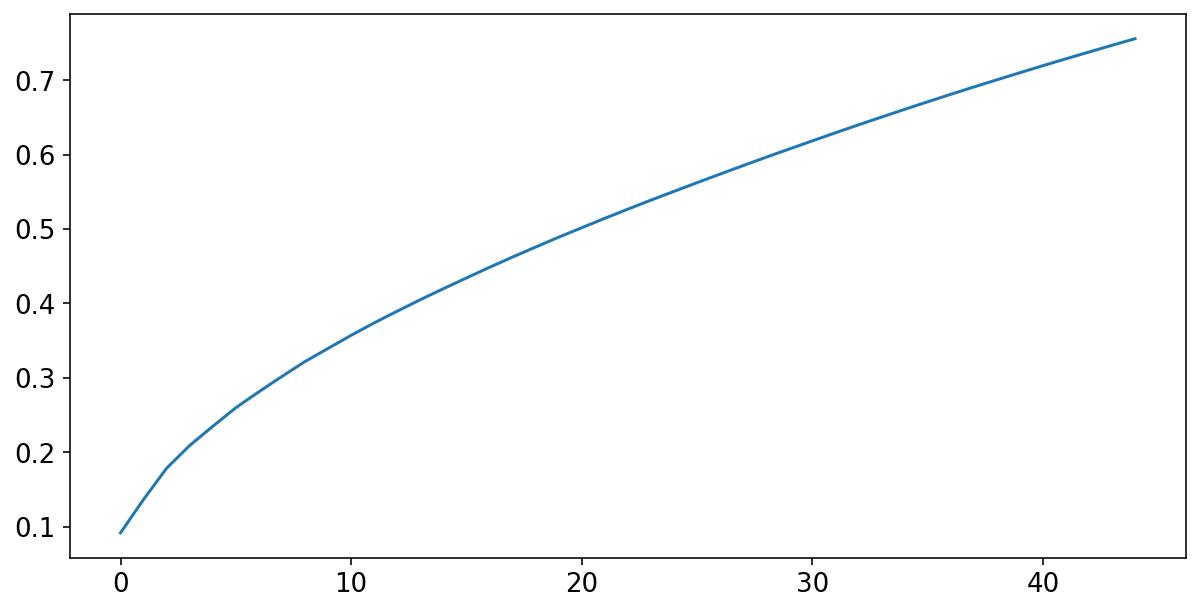

In [102]:
#Con base en el analisis anterior seleccionamos 45 componentes principales ya que contienen cerca del 85% de varianza
pca= PCA(n_components=45,svd_solver="full")
pca.fit(columns_ohe)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [103]:
columns_ohe_pca=pca.transform(columns_ohe)

In [104]:
columns_ohe_pca

array([[ 2.50004444,  1.60406898, -1.48274198, ...,  0.57596475,
        -0.15948412, -0.24416731],
       [-1.00639154, -1.30934856,  2.44165639, ...,  1.79680373,
        -1.3562073 ,  0.15680795],
       [ 2.6568409 ,  1.40260601, -1.32619071, ...,  0.2991326 ,
         0.33792194, -0.09084215],
       ...,
       [ 1.00605978,  3.67405029,  1.95973991, ...,  1.69292668,
         0.49879072, -0.76980657],
       [-2.62578936, -2.69958702,  0.58756669, ..., -0.93800892,
        -2.12574778,  1.68131536],
       [-1.78142137, -2.23627533,  1.47040654, ..., -1.62086893,
         0.21894743,  1.09208398]])

In [105]:
#Creamos nuestro pipeline que utiliza PCA y Lasso como modelo
pipe = Pipeline([
    ("select_cols", column_selector),
    ("pca",pca),
    ("lasso", Lasso(alpha=0.1, tol=0.5))
])

In [106]:
#Corremos el modelo y evaluamos nuestra R^2, que resulta en .67, lo cual implica que el modelo explica el 67% de la varianza
train, test = train_test_split(housing_train, test_size=0.2, random_state=2501)
xtrain, ytrain = train.drop("SalePrice", axis=1), train.loc[:,['SalePrice']]

cv = cross_validate(pipe, xtrain, ytrain, cv=5, scoring=["r2", "neg_mean_absolute_error"])
r2 = cv["test_r2"]
mae = -cv["test_neg_mean_absolute_error"]

In [107]:
print(f"mean r2: {r2.mean():0.2f}")
print(f"mean mae: {mae.mean():,.2f}")

mean r2: 0.81
mean mae: 19,528.31
